<a href="https://colab.research.google.com/github/Kamyar-V2/RDW/blob/main/RDW_Timing_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install git+https://github.com/pycroscopy/atomai # install the latest version from source
! pip install gdown==4.6.2
! pip install --upgrade jax jaxlib
! pip install scikit-optimize scipy numpy
! pip install GPyOpt
! pip install platypus-opt
! pip install -q kornia atomai git+https://github.com/ziatdinovmax/pyroVED@main
! pip install --upgrade matplotlib
! pip install --upgrade setuptools

In [10]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from PIL import Image
from skopt.space import Real, Integer
from skimage import feature, io
import random
import cv2
import skimage
from sklearn.mixture import GaussianMixture
import matplotlib.cm as cm
from GPyOpt.methods import BayesianOptimization
import GPy
from platypus import Problem, Real, NSGAII, Solution
import time
import math
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import distance_transform_edt
from atomai.transforms import datatransform
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from skimage.morphology import disk, dilation
from skimage.measure import label, regionprops
from torchvision.utils import make_grid
from sklearn.metrics import pairwise_distances_argmin_min
import torch
import pyroved as pv
from scipy.stats import gaussian_kde
tt = torch.tensor
np.random.seed(42)

Prepared data

In [11]:
# download data
!gdown "https://drive.google.com/uc?id=18U8YHZUbSZj0Q1__zup5-ABrjaEZmiPc"
# download model
!gdown "https://drive.google.com/uc?id=18PQs7M_fBp4Lf0JVQlORERmBmYRJ88-M"
# SrTio3
!gdown --id 1OOSnDPGrlKJums5-nDwyK_sJpL4aBLuq # SrTiO3
# download DCNN weights Graphene
!gdown 1SYEhCvo2-Bdv37Od0VZohurlnm3LSWCB
# download YBCO
!gdown 1DxFa0ra4TG88QFvuAVD9hyqbEJpE_w1S

Downloading...
From: https://drive.google.com/uc?id=18U8YHZUbSZj0Q1__zup5-ABrjaEZmiPc
To: /content/Gr_SiCr.npy
100% 4.19M/4.19M [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=18PQs7M_fBp4Lf0JVQlORERmBmYRJ88-M
To: /content/G_MD.tar
100% 11.1M/11.1M [00:00<00:00, 131MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OOSnDPGrlKJums5-nDwyK_sJpL4aBLuq
To: /content/instrument_SrTiO3.npz
100% 8.39M/8.39M [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SYEhCvo2-Bdv37Od0VZohurlnm3LSWCB
To: /content/abc.tar
100% 7.21M/7.21M [00:00<00:00, 81.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DxFa0ra4TG88QFvuAVD9hyqbEJpE_w1S
To: /content/YBCO.tif
100% 8.40M/8.40M [00:00<00:00, 15.1MB/s]


Dowload training dataset for DCNN model

In [12]:
#Hexagonal train/test dataset
!wget -O "Hex_train_test3.npz" https://www.dropbox.com/s/aldxrawcf88btkc/Hex_train_test3.npz?dl=0

--2024-08-27 12:43:05--  https://www.dropbox.com/s/aldxrawcf88btkc/Hex_train_test3.npz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/93idimc2luy6bj9dvpa45/Hex_train_test3.npz?rlkey=48ouxyabmnxfgfyw0y4pmkvi3&dl=0 [following]
--2024-08-27 12:43:06--  https://www.dropbox.com/scl/fi/93idimc2luy6bj9dvpa45/Hex_train_test3.npz?rlkey=48ouxyabmnxfgfyw0y4pmkvi3&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc004c3099d3aa5838bf07eef0a1.dl.dropboxusercontent.com/cd/0/inline/CZYIJ1HXtjvM_du5icY6YFZaKXSrpY0PwePUUt3xYj4GoB-3acJUVHsRTsgCAQ6aspEwRsftUJWT5nKsLhz0Q6IhKnvyUIRIIL963R76zlVImtuRuuWqS9Ls7qO82RIX5KpMyF8Ev7LwhOKg8q8A7lgz/file# [following]
--2024-08-27 12:43:07--  https://uc004c3099d3aa5838bf07eef0a1.

Also download already trained model

In [13]:
# model
!gdown 1SYEhCvo2-Bdv37Od0VZohurlnm3LSWCB

Downloading...
From: https://drive.google.com/uc?id=1SYEhCvo2-Bdv37Od0VZohurlnm3LSWCB
To: /content/abc.tar
100% 7.21M/7.21M [00:00<00:00, 75.7MB/s]


Important functions

In [14]:
def extract_subimages_2(image, subimage_size, num_subimages, seed):
    np.random.seed(seed)  # Set the random seed for reproducibility
    height, width = image.shape
    positions = set()
    subimage_slides = []

    while len(positions) < num_subimages:
        x = np.random.randint(0, height - subimage_size[0] + 1)
        y = np.random.randint(0, width - subimage_size[1] + 1)
        pos = (x, y)
        if pos not in positions:
            positions.add(pos)
            subimage = image[x:x + subimage_size[0], y:y + subimage_size[1]]
            subimage_slides.append(subimage)

    return subimage_slides

In [15]:
def apply_model_to_subimages(subimage_slides):
    nn_outputs = []
    coordinates_list = []
    image_indices = []
    timing_list = []  # Initialize an empty list to store timing information

    for idx, image in enumerate(subimage_slides):
        # Start timing for this operation
        st = time.time()

        # Use the model to predict on the subimage
        nn_output, coordinates = model.predict(image)

        # Stop timing and calculate elapsed time
        sf = time.time()
        elapsed_time = sf - st
        timing_list.append(elapsed_time)

        # Store the results
        nn_outputs.append(nn_output)
        coordinates_list.append(coordinates)
        image_indices.append(idx)

    coordinates_list = [list(d.values())[0] for d in coordinates_list]

    return nn_outputs, coordinates_list, subimage_slides, image_indices, timing_list

Taking a look at STEM images

In [16]:
#Graphene
path2 = "/content/Gr_SiCr.npy"
image_1 = np.load(path2)
#SrTio3
path3 = "/content/instrument_SrTiO3.npz"
image_2 = np.load(path3)
image_2  = image_2['img']
#YBCO
path = "/content/YBCO.tif"
image_3 = plt.imread(path)

(-0.5, 2047.5, 2047.5, -0.5)

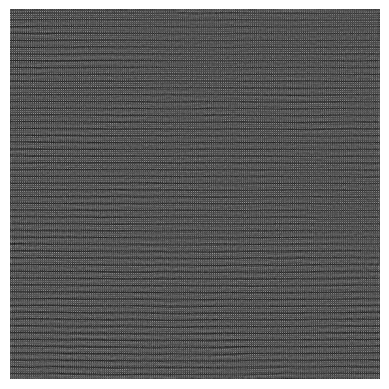

In [17]:
plt.imshow(image_3, cmap = "gray")
plt.axis("off")

## DCNN TRAINING

Load train/test data (this is a simple dataset generated just from a single image)

In [18]:
dataset = np.load("Hex_train_test3.npz")
images = dataset["X_train"]
labels = dataset["y_train"]
images_test = dataset["X_test"]
labels_test = dataset["y_test"]

In [19]:
print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

(1280, 1, 256, 256) (1280, 256, 256)
(320, 1, 256, 256) (320, 256, 256)


Let's plot some of the original training data:

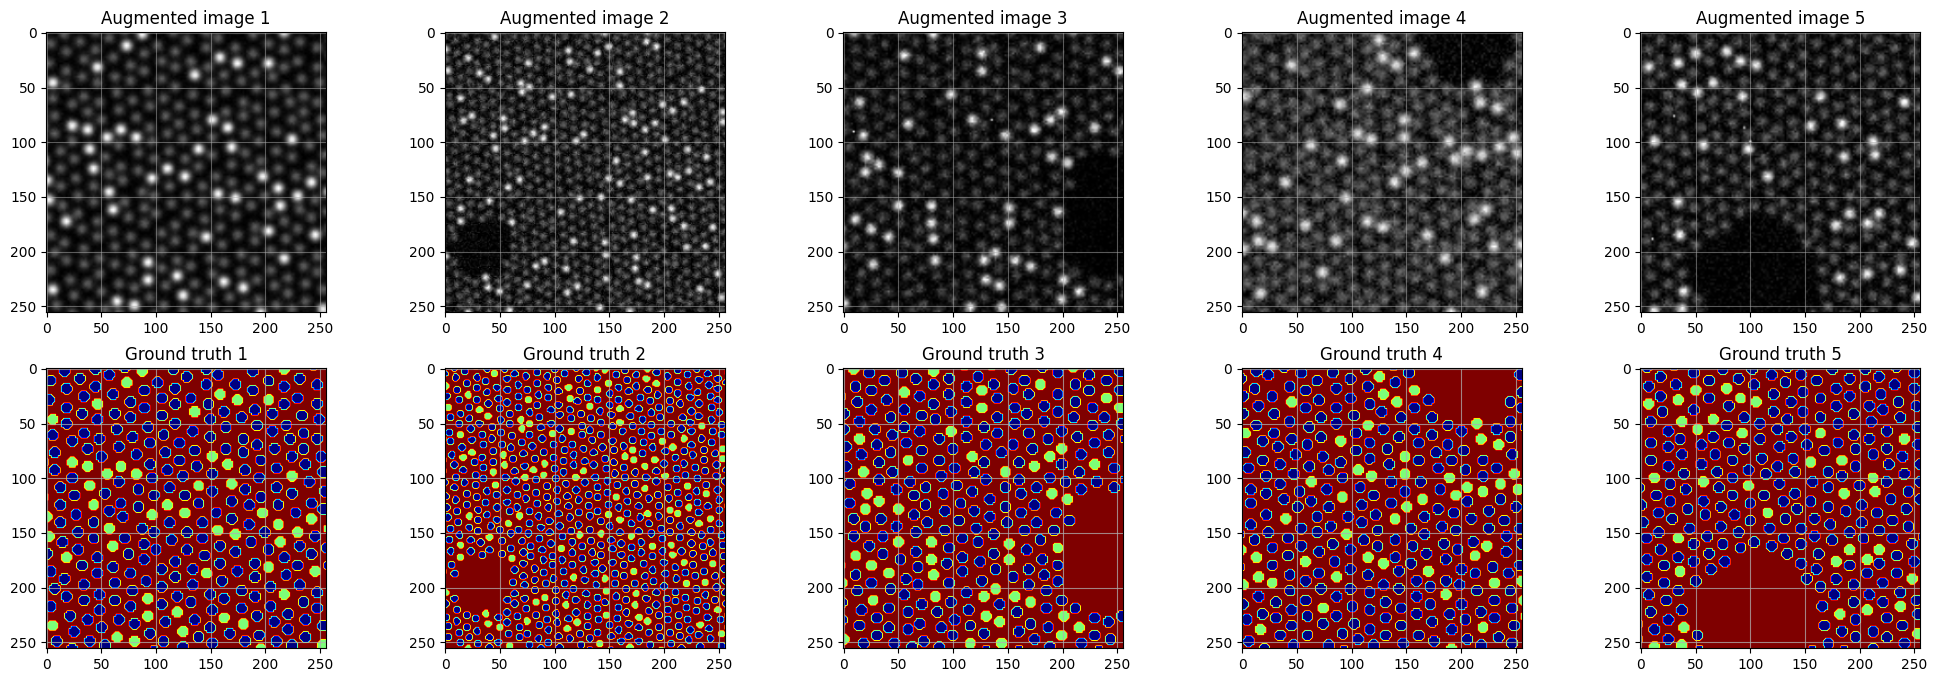

In [20]:
n = 5 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1], interpolation='Gaussian', cmap='jet')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)

Initializing neural network model for semantic segmentation

In [21]:
model = aoi.models.Segmentor(nb_classes=3)

In [ ]:
print(model.net)

Training the initialized model:

Epoch 1/300 ... Training loss: 1.116 ... Test loss: 1.1329 ... Train Accuracy: 0.1559 ... Test Accuracy: 0.088 ... GPU memory usage: 5393/23034
Epoch 100/300 ... Training loss: 0.1607 ... Test loss: 0.1587 ... Train Accuracy: 0.912 ... Test Accuracy: 0.9036 ... GPU memory usage: 5393/23034
Epoch 200/300 ... Training loss: 0.1322 ... Test loss: 0.104 ... Train Accuracy: 0.8981 ... Test Accuracy: 0.9196 ... GPU memory usage: 5393/23034
Epoch 300/300 ... Training loss: 0.1086 ... Test loss: 0.0851 ... Train Accuracy: 0.9118 ... Test Accuracy: 0.9235 ... GPU memory usage: 5393/23034
Model (final state) evaluation loss: 0.0976
Model (final state) accuracy: 0.9132
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.0933
Model (final state) accuracy: 0.9212
Plotting training history


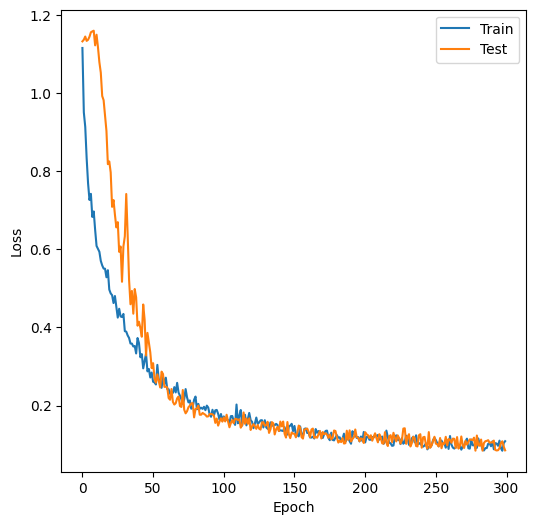

In [23]:
# Start the timer
start_time = time.time()

# Train the model
model.fit(images, labels, images_test, labels_test,  # training data
          training_cycles=300, compute_accuracy=True, swa=True  # training parameters
          )

# End the timer
end_time = time.time()

# Calculate the total training time
Total_training_time_DCNN = end_time - start_time

Now let's make a prediction on the image from a different experiment ( YBCO ). Notice that the raw output is a set of semantically segmented blobs (corresponding to different atoms) on a uniform background. We then simply find their centers of the mass, which correspond to the atomic centers (if a network was properly trained).

We check the DCNN model to predict the atoms coordinates of 256*256 subimages

(10, 256, 256)


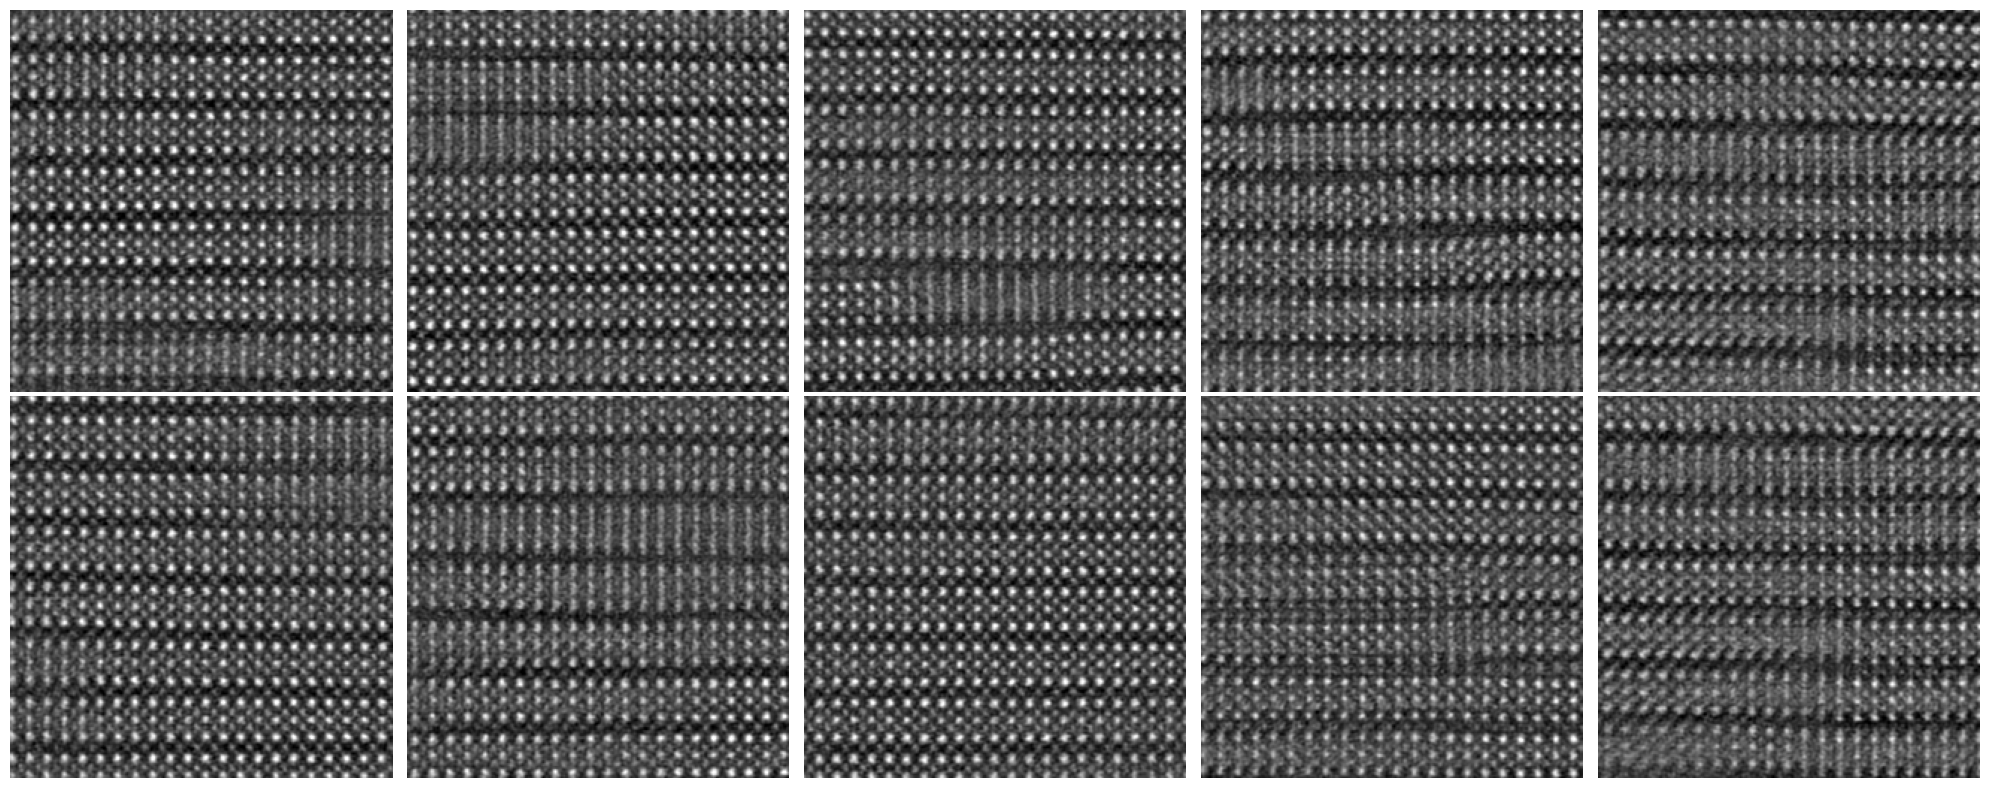

In [24]:
# Example usage with a dummy image
image = image_3
subimage_size=(256, 256)
num_subimages=10
seed=42
subimage_slides = extract_subimages_2(image, subimage_size, num_subimages, seed)

subimage_slides = np.array(subimage_slides)
print(subimage_slides.shape)

# Display the subimages
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, subimage in enumerate(subimage_slides):
    axes[i].imshow(subimage, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

TEST DCNN

In [50]:
import time
nn_outputs, coordinates_list, subimage_slides, image_indices, timing_list = apply_model_to_subimages(subimage_slides)

Batch 1/1
1 image was decoded in approximately 0.015 seconds
Batch 1/1
1 image was decoded in approximately 0.0124 seconds
Batch 1/1
1 image was decoded in approximately 0.0121 seconds
Batch 1/1
1 image was decoded in approximately 0.012 seconds
Batch 1/1
1 image was decoded in approximately 0.0134 seconds
Batch 1/1
1 image was decoded in approximately 0.0118 seconds
Batch 1/1
1 image was decoded in approximately 0.0117 seconds
Batch 1/1
1 image was decoded in approximately 0.012 seconds
Batch 1/1
1 image was decoded in approximately 0.0119 seconds
Batch 1/1
1 image was decoded in approximately 0.0121 seconds


In [51]:
timing_list

[0.018960952758789062,
 0.014695167541503906,
 0.014292240142822266,
 0.01355886459350586,
 0.015621185302734375,
 0.013345718383789062,
 0.013498783111572266,
 0.014661550521850586,
 0.01349949836730957,
 0.014264106750488281]

How it did

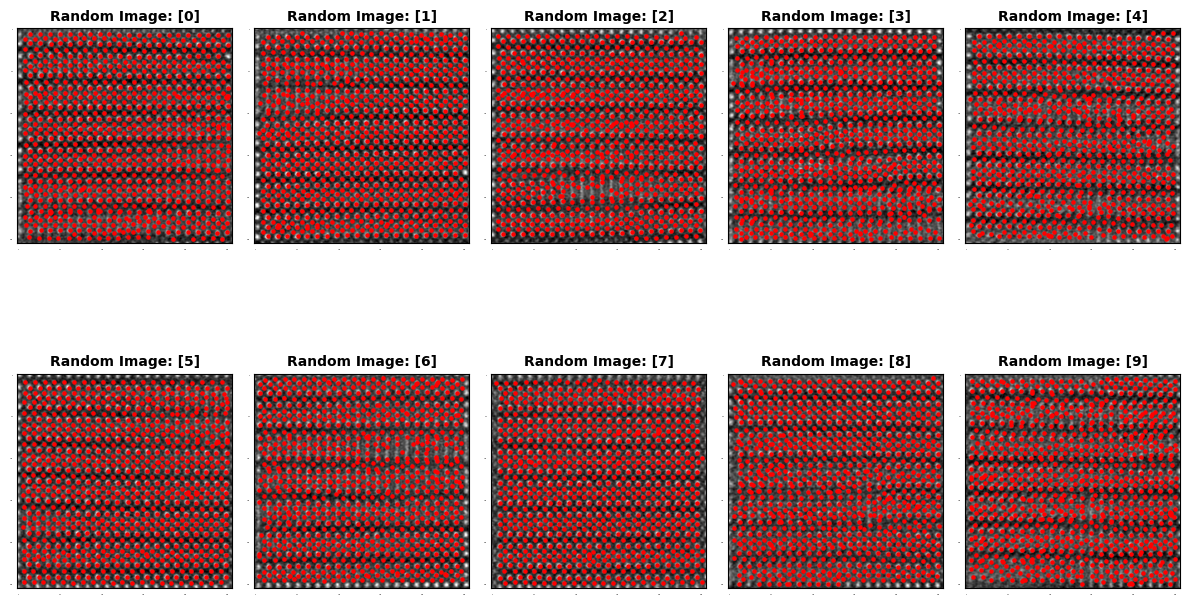

In [27]:
fig, axes = plt.subplots(2, 5, figsize=(12, 8))  # 2 rows, 5 columns of plots
#fig, axes = plt.subplots(13, 5, figsize=(20, 50), dpi = 200)

for i, ax in enumerate(axes.flatten()):
    if i < len(coordinates_list):
        x = coordinates_list[i][:, 1]  # All rows, first column
        y = coordinates_list[i][:, 0]  # All rows, second column

        # Display the image
        ax.imshow(subimage_slides[i], cmap='gist_gray')

        # Scatter plot of coordinates on the image
        ax.scatter(x, y, marker='o', c="r", s=5)

        # Changing the tick size
        ax.tick_params(axis='both', which='both', length=0, labelsize=0)

        # Setting title to indicate the noise level
        ax.set_title(f'Random Image: {[i]}', fontsize=10, fontweight = "bold")
    else:
        ax.axis('off')  # Hide unused subplots

plt.tight_layout()
plt.show()

## RDW workflow

In [28]:
Oracle_A = len(coordinates_list[7])
#plt.imshow(subimage_slides[7])
print(Oracle_A)

830


In [29]:
# min-max normalization:
def norm2d(img: np.ndarray) -> np.ndarray:
    return (img - np.min(img)) / (np.max(img) - np.min(img))

In [30]:
def apply_log(image, min_sigma, max_sigma, threshold, overlap):

    preprocessed_img = norm2d(image)
    array_3d = preprocessed_img[None, :, :]

    num_sigma = 20
    #window_size = 20 # for YBCO
    #window_size = 10 # For SrTiO3
    window_size = 20 # for graphene

    # Initialize arrays for results
    coordinates = np.zeros((1, 3))
    coms = np.zeros((1, 3))
    imstack_grid = np.zeros((1, window_size, window_size, 1))

    # Process the preprocessed image
    imglist = [0]  # Assuming you're processing a single image in this case
    for i in imglist:
        img_to_analyze = norm2d(array_3d[i])  # Apply norm2d to the slice from array_3d

        # Apply LoG filter to detect atoms using the provided parameters
        all_atoms = feature.blob_log(preprocessed_img, min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold, overlap=overlap)

        if len(all_atoms) == 0:
            return np.array([]), 0

        coordinate = np.full_like(all_atoms, i)
        coordinate[:, :-1] = all_atoms[:, :-1]

        # Attempt to extract sub-images around detected atoms
        try:
            imstack, com, frames = aoi.utils.extract_subimages(img_to_analyze, coordinate[:, :-1], window_size)
            com = np.array(com)
            if com.size == 0:  # Check if the 'com' array is empty
                continue  # Skip the rest of the loop if no sub-images were extracted

            com_ = np.full((len(com), 3), i)
            com_[:, :-1] = com
            imstack = (imstack - imstack.min()) / (imstack.max() - imstack.min())  # Normalize sub-images

            # Accumulate results
            coms = np.concatenate((coms, com_), axis=0)
            coordinates = np.concatenate((coordinates, coordinate), axis=0)
            imstack_grid = np.concatenate((imstack_grid, imstack), axis=0)
        except ValueError as e:
            print(f"Error processing image index {i}: {e}")
            continue  # Optionally log the error and skip this iteration

    # Remove the initial placeholder row
    coordinates = coordinates[1:]
    coms = coms[1:]
    imstack_grid = imstack_grid[1:]

    return coms, len(coms)

In [31]:
def Error_count(params, image):

    min_sigma, max_sigma, threshold, overlap = params
    coms, log_count = apply_log(image, min_sigma, max_sigma, threshold, overlap)

    # Safeguard for n_neighbors to not exceed number of samples
    #n_neighbors = min(len(coms), 4)  # 4 for graphene
    n_neighbors = min(len(coms), 5)  # 5 for SrTiO3

    # Calculate the sum of distances to the nearest neighbors for each point
    if n_neighbors > 1:  # Proceed only if there are at least 2 points (1 neighbor besides itself)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(coms)
        distances, _ = nbrs.kneighbors(coms)
        sum_of_distances = np.sum(distances[:, 1:], axis=1)  # Exclude the distance to itself (first column)
    else:
        sum_of_distances = np.array([0] * len(coms))  # If only 1 sample, the sum of distances is 0

    # Count points with the sum of distances below a certain threshold
    points_below_threshold = np.sum(sum_of_distances < 30)
    #points_below_threshold = np.sum(sum_of_distances < 70) # for SrTiO3

    normalized_points = points_below_threshold / Oracle_A  # Assuming Oracle_A is defined and non-zero

    return normalized_points

In [32]:
def Quality_count(params, image):
    min_sigma, max_sigma, threshold, overlap = params
    coms, log_count = apply_log(image, min_sigma, max_sigma, threshold, overlap)

    difference = abs((log_count - Oracle_A)/Oracle_A)

    return difference

In [33]:
class MyOptimizationProblem(Problem):
    def __init__(self, image):
        super(MyOptimizationProblem, self).__init__(4, 2)  # Assuming 4 decision variables and 2 objectives
        self.image = image
        self.types[:] = [Real(0.1, 2.0), Real(1.0, 2.0), Real(0.01, 0.3), Real(0.01, 0.5)] # For YBCO
        #self.types[:] = [Real(1, 10), Real(1, 20), Real(0.01, 1.0), Real(0.1, 1.0)] #for graphene
        #self.types[:] = [Real(0.1, 5.0), Real(1.0, 10.0), Real(0.01, 0.3), Real(0.01, 1.0)] # for SrTiO3

        self.directions[:] = [Problem.MINIMIZE, Problem.MINIMIZE]

    def evaluate(self, solution):
        min_sigma, max_sigma, threshold, overlap = solution.variables

        error = Error_count([min_sigma, max_sigma, threshold, overlap], self.image)
        quality = Quality_count([min_sigma, max_sigma, threshold, overlap], self.image)
        # penalty_factor = 5
        # penalized_error = error * penalty_factor

        solution.objectives[:] = [error, quality]

TEST THE LOG* model

In [ ]:
best_results = []  # List to store the best results for each image
iteration_times = []  # List to store the times for each iteration
acquiring_times = []  # List to store the times for extracting log_count and len_coms
total_start_time = time.time()  # Start timing for the entire optimization process

for image in subimage_slides:
    start_time = time.time()  # Start timing for this iteration

    problem = MyOptimizationProblem(image)
    algorithm = NSGAII(problem)
    algorithm.run(10)  # Run the optimization algorithm
    solutions = algorithm.result  # Gather all solutions

    # Collect objectives from all solutions and calculate Euclidean distances
    objectives = [s.objectives[:] for s in solutions]
    ideal_point = [0, 0]  # Define your ideal point here
    euclidean_distances = [np.sqrt(np.sum((np.array(obj) - np.array(ideal_point)) ** 2)) for obj in objectives]
    best_solution_index = np.argmin(euclidean_distances)  # Find the index of the best solution
    best_solution = solutions[best_solution_index]  # Select the best solution based on the minimum distance

    # Timing for extracting the best log_count and len_coms
    acquiring_start_time = time.time()
    coms, log_count = apply_log(image, *best_solution.variables)  # Ensure variables are unpacked correctly
    acquiring_time = time.time() - acquiring_start_time
    acquiring_times.append(acquiring_time)

    # Calculate and store the total time taken for this iteration
    iteration_time = time.time() - start_time
    iteration_times.append(iteration_time)

    # Store the best parameters, objectives, and log_count
    best_results.append({
        'best_parameters': best_solution.variables,
        'best_objectives': best_solution.objectives,
        'log_count': log_count,
        'coms': coms
    })

    # Print the best parameters and their corresponding results for this iteration
    print(f"Best Parameters for current image: {best_solution.variables}")
    print(f"Objectives: {best_solution.objectives}")
    print(f"Log count: {log_count}")
    print(f"Time taken for acquiring best solution: {acquiring_time:.2f} seconds")
    print(f"Total time taken for this iteration: {iteration_time:.2f} seconds")

# Calculate the total optimization time for all images
total_optimization_time = time.time() - total_start_time

# Optionally, display or save the collected best results
print("All best results:", best_results)

# Calculate and display the average time for the iterations and acquiring
average_iteration_time = sum(iteration_times) / len(iteration_times)
average_acquiring_time = sum(acquiring_times) / len(acquiring_times)
print(f"Average time per iteration: {average_iteration_time:.2f} seconds")
print(f"Average time for acquiring best solution: {average_acquiring_time:.2f} seconds")
print(f"Total optimization time for all images: {total_optimization_time:.2f} seconds")


In [72]:
# Timing for extracting the best log_count and len_coms
import time
acquiring_times = []
for image in subimage_slides:

    acquiring_start_time = time.time()
    coms, log_count = apply_log(image, *best_solution.variables)  # Ensure variables are unpacked correctly
    acquiring_time = time.time() - acquiring_start_time
    acquiring_times.append(acquiring_time)

In [35]:
st = time.time()  # Start timing

log_counts = [result['log_count'] for result in best_results]
best_parameters = [result['best_parameters'] for result in best_results]
best_objectives = [result['best_objectives'] for result in best_results]
best_coms = [result['coms'] for result in best_results]

sf = time.time()

print(sf-st)

0.00020313262939453125


Timing test LoG vs DCNN

In [36]:
timing_list

[0.1438460350036621,
 0.0157163143157959,
 0.016686439514160156,
 0.016611337661743164,
 0.014800071716308594,
 0.014986276626586914,
 0.014434337615966797,
 0.014582395553588867,
 0.013939857482910156,
 0.013927698135375977]

In [73]:
acquiring_times

[0.14154267311096191,
 0.13816571235656738,
 0.13705110549926758,
 0.14551544189453125,
 0.1431293487548828,
 0.1376194953918457,
 0.13707566261291504,
 0.13854694366455078,
 0.1377720832824707,
 0.13857555389404297]

In [4]:
Total_training_time_DCNN

NameError: name 'Total_training_time_DCNN' is not defined

In [39]:
total_optimization_time

306.9494659900665

In [47]:
# Generate example timing data for two methods
method_a_times = timing_list
method_b_times = iteration_times
#Total_training_time_DCNN = 155.0888
Total_training_time_DCNN = Total_training_time_DCNN
#Total_optimization_time_for_ten_images = 363.17
Total_optimization_time_for_ten_images = total_optimization_time
iteration_optimization_times_LoG = iteration_times
Inference_times_for_ten_LoG = acquiring_times
Inference_times_for_ten_DCNN= timing_list

In [48]:
import pickle

# Prepare the data as a dictionary
data = {
    'method_a_times': method_a_times,
    'method_b_times': iteration_times,
    'Total_training_time_DCNN': Total_training_time_DCNN,
    'Total_optimization_time_for_ten_images': Total_optimization_time_for_ten_images,
    'iteration_optimization_times_LoG': iteration_optimization_times_LoG,
    'Inference_times_for_ten_LoG': Inference_times_for_ten_LoG,
    'Inference_times_for_ten_DCNN': Inference_times_for_ten_DCNN
}

# Save the data to a pickle file
with open('timing_data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [3]:
with open('timing_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Accessing the data
method_a_times = loaded_data['method_a_times']

FileNotFoundError: [Errno 2] No such file or directory: 'timing_data.pkl'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.ticker import FuncFormatter

# Function to format x-ticks
def scientific_notation_formatter(x, pos):
    return f'{x:.2e}'

# Consistent Legend Style
legend_style = {
    'loc': 'upper left',
    'frameon': True,
    'fancybox': True,
    'framealpha': 1,
    'borderpad': 1,
    'edgecolor': 'black',
    'labelspacing': 1,
    'fontsize': 16
}

# === Plot 1: Density Plot for Acquisition Times === #

# Generate density data for both methods
density_a = gaussian_kde(Inference_times_for_ten_DCNN)
density_b = gaussian_kde(Inference_times_for_ten_LoG)

# Calculate the minimum and maximum time values across both methods
start_time = min(min(Inference_times_for_ten_DCNN), min(Inference_times_for_ten_LoG))
end_time = max(max(Inference_times_for_ten_DCNN), max(Inference_times_for_ten_LoG))

# Avoid zero in logarithmic scale by ensuring start_time is positive
if start_time <= 0:
    start_time = 1e-3

# Create a range of time values to plot the densities, starting from the minimum to the maximum
time_values = np.logspace(np.log10(start_time), np.log10(end_time), 1000)

# Plot the density curves
plt.figure(figsize=(8, 8), dpi=100)
plt.plot(time_values, density_a(time_values), label='DCNN', color='blue', linewidth=2)
plt.plot(time_values, density_b(time_values), label='LoG', color='red', linewidth=2)

# Fill areas under the curves
plt.fill_between(time_values, density_a(time_values), alpha=0.3, color='blue')
plt.fill_between(time_values, density_b(time_values), alpha=0.3, color='red')

# Add labels and title
plt.title('Inference Time Distribution: DCNN vs LoG*', fontsize=20, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=20, fontweight='bold')
plt.ylabel('Density', fontsize=20, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# Set x-axis to logarithmic scale
plt.xscale('log')

# Set custom x-ticks and format them with scientific notation
plt.xticks(np.logspace(np.log10(start_time), np.log10(end_time), 3), fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(scientific_notation_formatter))

# Set y-ticks
plt.yticks(np.linspace(0, max(density_a(time_values)), 3), fontsize=16)

# Add legend with bold font and specific fontsize
plt.legend(loc='upper right', frameon=True, fancybox=True, framealpha=1, borderpad=1, edgecolor='black', labelspacing=1, handlelength=2)
plt.setp(plt.gca().get_legend().get_lines(), linewidth=3)

# Show the plot
plt.show()

# === Plot 2: Bar Chart for LoG Optimization vs DCNN Training === #

# Data preparation
log_times = iteration_optimization_times_LoG  # List of ten LoG optimization times
dcnn_time = Total_training_time_DCNN

# Calculate mean and standard deviation for LoG times
mean_log_time = np.mean(log_times)
std_log_time = np.std(log_times)

# Data for plotting
methods = [1, 2]  # Using 1 and 2 as the x labels
times = [mean_log_time, dcnn_time]
errors = [std_log_time, 0]  # No error bar for DCNN as it's a single value

# Create a figure
plt.figure(figsize=(8, 8), dpi=100)

# Create a bar chart with error bars
bars = plt.bar(methods, times, yerr=errors, width=0.6, capsize=20, color=['#56A3A6', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)

# Add timing values on top of the bars with enhanced font
for bar, time in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width() / 2 , bar.get_height() + max(errors) * 1.5, f'{time:.2f} sec',
             ha='center', va='bottom', fontsize=16, fontweight='bold', color='black')

# Set limits and labels
plt.ylim(0, max(times) * 1.1)
plt.ylabel('Time (seconds)', fontsize=20, fontweight='bold')
plt.xlabel('Methods', fontsize=20, fontweight='bold')

# Make x-ticks bold and y-ticks normal
plt.xticks([1, 2], labels=['1', '2'], fontsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)
for tick in plt.gca().get_xticklabels():
    tick.set_fontweight('normal')
for tick in plt.gca().get_yticklabels():
    tick.set_fontweight('normal')

# Adjust legend style to be at the top left for the second plot
legend_style_left = legend_style.copy()
legend_style_left['loc'] = 'upper left'  # Move the legend to the top left

# Add legend with adjusted style matching the bar colors
plt.legend(bars, ['LoG*', 'DCNN'], **legend_style_left)

plt.title('LoG Optimization - DCNN Training', fontsize=20, fontweight='bold')

# Add consistent grid
plt.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


NameError: name 'Inference_times_for_ten_DCNN' is not defined